In [1]:
from utils import DeepWalk

import networkx as nx
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from matplotlib import pyplot as plt
from tqdm import tqdm

### Vanilla DeepWalk on Karate Club graph to test the plausibility of DeepWalk implementation 

In [2]:
G = nx.karate_club_graph()

In [3]:
model = DeepWalk(G, 
                 10, 
                 128, 
                 10, 
                 40, 
                 0.025, 
                 0,
                 False, 
                 None, 
                 None, 
                 None)

In [4]:
model.train()

In [5]:
X1 = model.Phi 

In [6]:
club_colors = {
    'Mr. Hi': 'green',
    'Officer': 'red'
}

node_colors = [club_colors[G.nodes[node]['club']] for node in G.nodes]

pos = nx.spring_layout(G)  

pca = PCA(n_components=2)
principal_components = pca.fit_transform(model.Phi)

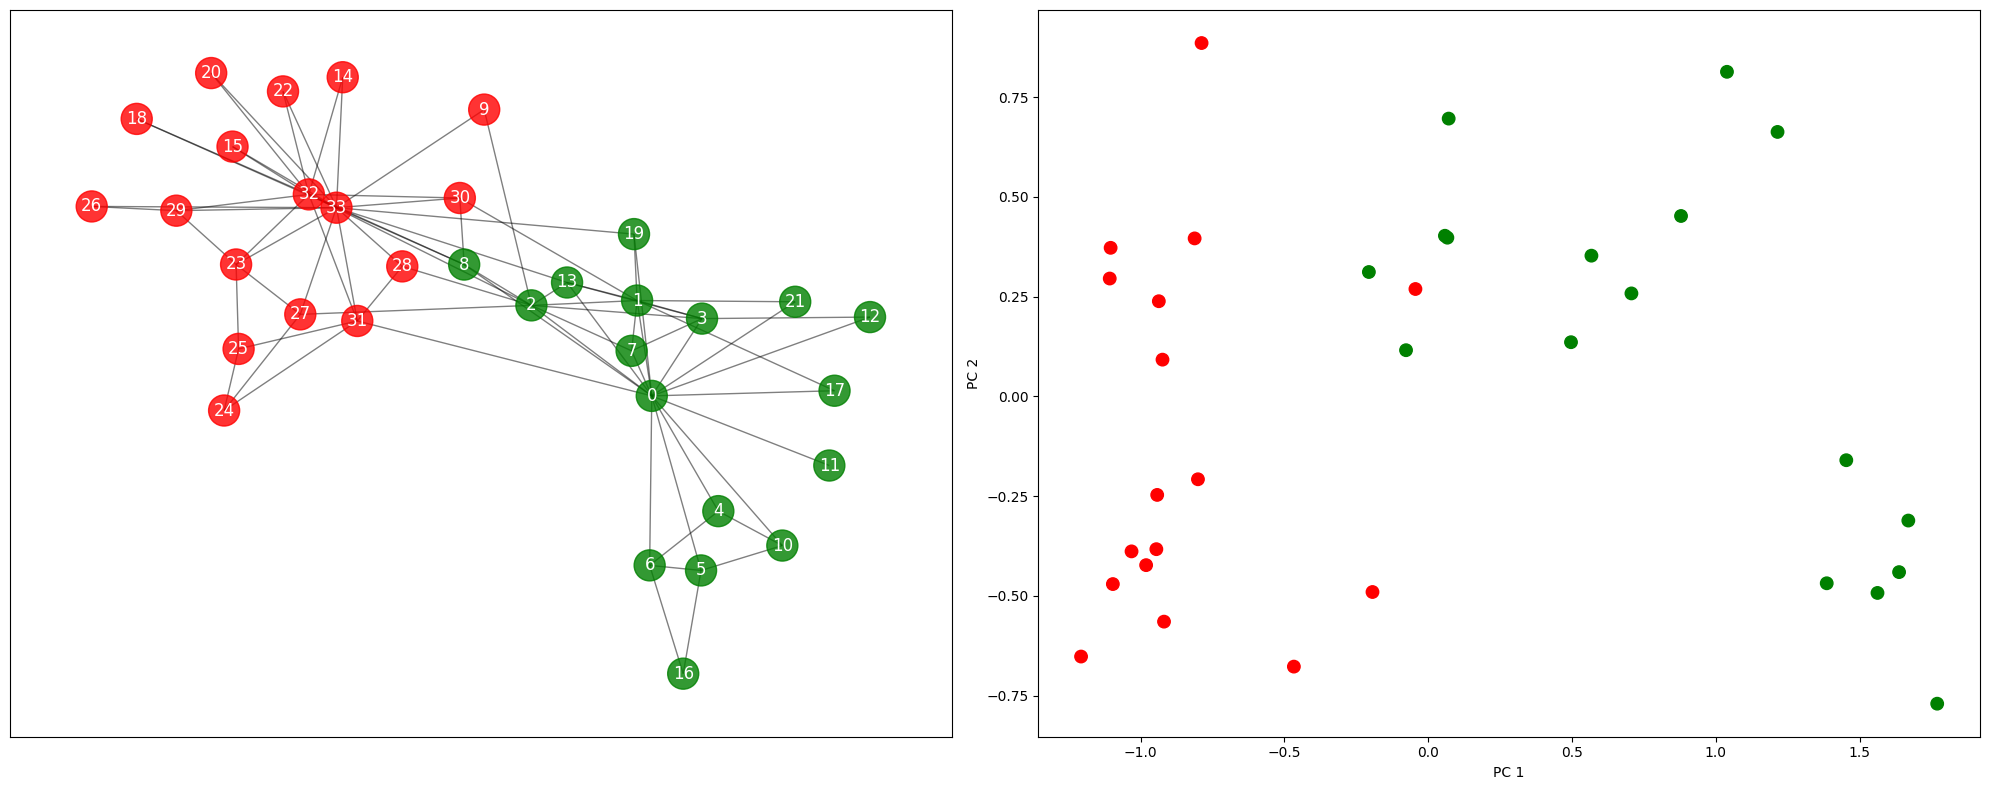

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, alpha=0.8, ax=axes[0])
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=axes[0])
nx.draw_networkx_labels(G, pos, font_size=12, font_color='white', ax=axes[0])

axes[1].scatter(principal_components[:,0], 
                principal_components[:,1],
                s=80, 
                color=node_colors)

axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')

plt.tight_layout()
plt.show()

_______________________

## Generating synthetic node signals dataset over karate club graph 

In [8]:
G = nx.karate_club_graph()

In [9]:
classes = [G.nodes[node]['club'] for node in G.nodes]

In [10]:
N = len(classes)
D = 100
C = 2 

M = 1000

In [11]:
# Generating data from different normal distribution for the different classes

nodes_data = np.zeros((N*D, M))

distros = {
    label: {
        'mu': np.random.normal(0, 5, D),
        'var': np.eye(D)
    }
    for label in set(classes)
}

labels = {
    0: 'Mr. Hi',
    1: 'Officer'
}

In [12]:
for node in tqdm(range(N)):
    i = classes[node]
    classes[node] = i
    mu = distros[i]['mu']
    var = distros[i]['var']

    nodes_data[node*D:(node+1)*D,:] = (np.random.multivariate_normal(mean = mu, cov = var, size = M) +                               # True signal
                                       np.random.multivariate_normal(mean = np.zeros(D),  cov = 0.01*np.eye(D), size = M)).T         # Noise

100%|██████████| 34/34 [00:00<00:00, 70.14it/s]


In [13]:
edges_array = np.zeros((2, len(G.edges)), dtype='int32')

In [14]:
edges_array.shape

(2, 78)

In [15]:
for i, edge in enumerate(list(G.edges)):
    edges_array[0,i] = edge[0]
    edges_array[1,i] = edge[1]

In [16]:
nodes = np.arange(N)

In [17]:
from utils import GraphSheaf

In [18]:
model = DeepWalk(G, 
                 10, 
                 128, 
                 10, 
                 40, 
                 0.025, 
                 0,
                 True, 
                 nodes_data, 
                 D, 
                 1)

In [19]:
model.Sheaf.builder()

100%|██████████| 78/78 [00:00<00:00, 91.14it/s]


In [20]:
model.train()

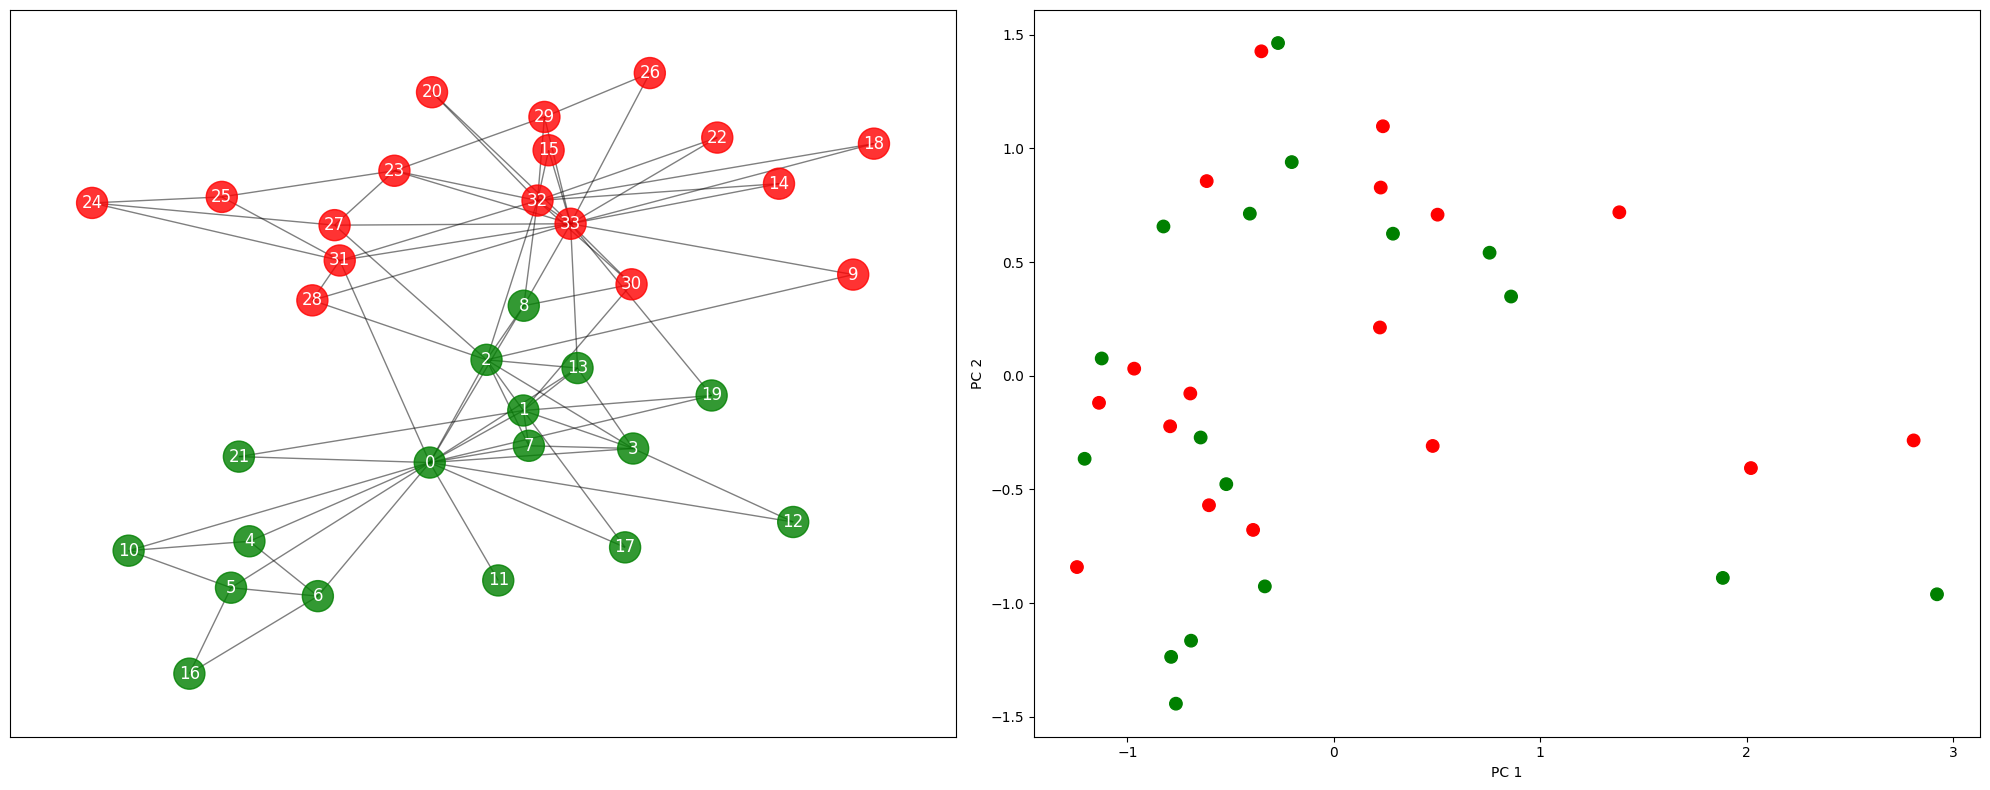

In [21]:
club_colors = {
    'Mr. Hi': 'green',
    'Officer': 'red'
}

node_colors = [club_colors[G.nodes[node]['club']] for node in G.nodes]

pos = nx.spring_layout(G)  

pca = PCA(n_components=3)
principal_components = pca.fit_transform(model.Phi)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, alpha=0.8, ax=axes[0])
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=axes[0])
nx.draw_networkx_labels(G, pos, font_size=12, font_color='white', ax=axes[0])

axes[1].scatter(principal_components[:,0], 
                principal_components[:,1],
                s=80, 
                color=node_colors)

axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')

plt.tight_layout()
plt.show()

In [22]:
X2 = model.Phi

# A first test

In [23]:
classes_ = np.zeros(34, dtype='int32')
for i in range(len(classes)):
    if classes[i] == 'Mr. Hi':
        classes_[i] = 1 

In [24]:
classes_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Standardize the features
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1, classes_, test_size=0.2, random_state=42)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Standardize the features
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1, classes_, test_size=0.2, random_state=42)

# Initialize the classifier
classifier = LogisticRegression()

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.8571
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.67      0.80         3

    accuracy                           0.86         7
   macro avg       0.90      0.83      0.84         7
weighted avg       0.89      0.86      0.85         7

Confusion Matrix:
[[4 0]
 [1 2]]


In [27]:
# Standardize the features
scaler = StandardScaler()
X2 = scaler.fit_transform(X2)

X_train, X_test, y_train, y_test = train_test_split(X2, classes_, test_size=0.2, random_state=42)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the classifier
classifier = LogisticRegression()

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.5714
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.50      0.67      0.57         3

    accuracy                           0.57         7
   macro avg       0.58      0.58      0.57         7
weighted avg       0.60      0.57      0.57         7

Confusion Matrix:
[[2 2]
 [1 2]]


__________

# CORA

In [2]:
from torch_geometric.datasets import Planetoid

c:\Users\Leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
dataset = Planetoid(root='/data', name='Cora', split='full')

In [4]:
data = dataset[0]

In [5]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [6]:
nodes = np.arange(0, data.x.shape[0])
edges = data.edge_index

In [7]:
edges_tail = edges[0,:]
edges_head = edges[1,:]

edges = [(edges_tail[i].item(), 
          edges_head[i].item()) for i in range(edges.shape[1])]

In [8]:
G2 = {
    'nodes':nodes,
    'edges':edges
}

In [9]:
model = DeepWalk(G2, 
                 10, 
                 128, 
                 10, 
                 40, 
                 0.025, 
                 0,
                 False, 
                 None, 
                 None, 
                 None)

In [ ]:
model.train()

In [12]:
X = model.Phi

In [14]:
data.y.detach().numpy()

array([3, 4, 4, ..., 3, 3, 3], dtype=int64)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data.y.detach().numpy(), test_size=0.2, random_state=42)

# Initialize the classifier
classifier = LogisticRegression()

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.7860
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.75        75
           1       0.69      0.67      0.68        46
           2       0.88      0.86      0.87        80
           3       0.85      0.79      0.82       191
           4       0.72      0.80      0.76        76
           5       0.73      0.84      0.78        44
           6       0.75      0.70      0.72        30

    accuracy                           0.79       542
   macro avg       0.76      0.78      0.77       542
weighted avg       0.79      0.79      0.79       542

Confusion Matrix:
[[ 57   1   1   7   4   3   2]
 [  4  31   5   2   2   2   0]
 [  0   2  69   7   0   2   0]
 [  7   9   2 150  17   4   2]
 [  2   0   1  10  61   1   1]
 [  2   1   0   1   1  37   2]
 [  6   1   0   0   0   2  21]]


c:\Users\Leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
